# Occlusion by

## Overview

1. Transform objects meshes to screen coordinates (i.e. pixel coordinates) with a depth value (i.e. Z-value)
2. For each mesh $k$, create a rasterized matrix $Z_k$ (2D map) which holds the Z-value for each pixel
3. Create a visibility matrix $V_{i,j}$ where each pixel holds the index of the lowest Z-value:

    $$
    V_{i, j} = \arg \min_{k} Z_k
    $$
4. Compute the visibility score:
    $$
    \frac{V == k}{Z_k}
    $$

## References

[1]  Richard Szeliski, Computer Vision: Algorithms and Applications, 2nd ed. 2022

In [150]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import math
import open3d as o3d

# own functions
from src.utils import identity_transform, create_transform_from_translation_and_yaw

## Create a set of objects in the scene

In [152]:
# object poses (x, y, z, yaw) in {world} frame
object_poses_world = [
    (10.0, 0.0, 1.0, 0.0),  # 10m in x, and 1.0m in z
    (13.0, 0.5, 1.0, 0.0),  # 13m in x, 0.5 to the left (y) and 1.0m in z
     # (8.0, 2.0, 1.0, 0.0),
]

In [153]:
dataset = o3d.data.BunnyMesh()
bunny_mesh = o3d.io.read_triangle_mesh(dataset.path)

In [154]:
# create object meshes in their corresponding {model} frame
objects_model = [
    o3d.geometry.TriangleMesh.create_sphere(radius=1, resolution=25),
    o3d.geometry.TriangleMesh.create_sphere(radius=1, resolution=25),
    # bunny_mesh.scale(5.0, center=np.asarray(bunny_mesh.vertices).mean(axis=0))
]

In [155]:
objects_world = list()

for object, pose in zip(objects_model, object_poses_world):
    T_world_model = create_transform_from_translation_and_yaw(pose[:3], pose[3])
    objects_world.append(object.transform(T_world_model))

In [156]:
# take a glimpse to the vertex coordinates
np.asarray(objects_world[0].vertices)[:4]

array([[10.        ,  0.        ,  2.        ],
       [10.        ,  0.        ,  0.        ],
       [10.12533323,  0.        ,  1.9921147 ],
       [10.12434494,  0.01570842,  1.9921147 ]])

## Transform the object meshes to screen coordinates

### Implement camera matrix (intrinsic & extrinsic)

In [157]:
@dataclass
class Camera:

    # parameters from [1] Eq. 2.57
    f_x: float
    f_y: float
    c_x: float
    c_y: float

    s: float = 0.0
    T_camera_world: np.ndarray = field(default_factory=identity_transform)

    @property
    def calibration_matrix(self) -> np.ndarray:
        return np.array([[self.f_x, self.s, self.c_x], [0, self.f_y, self.c_y], [0, 0, 1]], dtype=float)
    
    def set_transform(self, T: np.ndarray) -> None:
        """Set {camera} -> {world} transformation."""
        self.T_camera_world = T

    @property
    def camera_matrix(self) -> np.ndarray:
        """Camera matrix as defined in [1] Eq. 2.64

        Returns:
            np.ndarray: 4x4 matrix
        """
        C = identity_transform()
        C[:3, :3] = self.calibration_matrix
        camera_matrix = C @ self.T_camera_world
        return camera_matrix

    @classmethod
    def from_screensize(cls, W: int, H: int, f: float) -> "Camera":
        return cls(f, f, W//2, H//2, 0)

In [158]:
# screen size in px
W = 1600
H = 900

In [159]:
# [1] Equation 2.60
horizontal_fov_degrees = 60
horizontal_fov_rad = math.radians(horizontal_fov_degrees)
f = W/2 * 1/(math.tan(horizontal_fov_rad/2))

camera = Camera.from_screensize(W, H, f)

In [160]:
# create a {world}->{camera} matrix
T_w_c = identity_transform()

# camera axes as expressed in {world}
# optical axes is in parallel to x-{world} direction
T_w_c[:3, 0] = [0, -1, 0]  # x-axis of {camera} points in negative y-{world}
T_w_c[:3, 1] = [0, 0, 1]  # y-axis of {camera} points in positive z-{world}  
T_w_c[:3, 2] = [-1, 0, 0] # z-axis of {camera} points in negative x-{world}

camera_position = [0.0, 0.0, 1.0]  # 1m above ground!
T_w_c[:3, 3] = camera_position
T_c_w = np.linalg.inv(T_w_c)
camera.set_transform(T_c_w)

In [161]:
# 4x4 matrix used for upcoming transformations
C = camera.camera_matrix

### Apply camera matrix to transform vertices into screen coordinates

In [162]:
def apply_camera_matrix(C: np.ndarray, points: np.ndarray) -> np.ndarray:
    """Apply camera transformation to multiple points in world coordinates.

    Args:
        C (np.ndarray): camera 4x4 matrix
        points (np.ndarray): _description_
        normalize (bool, optional): _description_. Defaults to True.

    Returns:
        np.ndarray: Nx3 matrix, with each row representing (x_px, y_px, z-value)
    """

    num_points = points.shape[0]
    points_with_ones_column = np.r_[points.T, np.ones((1, num_points), dtype=float)]

    pts_transformed = C @ points_with_ones_column

    # normalize to z_{screen}=1.0
    pts_transformed /= pts_transformed[2, :]

    # compute z-values instead of d values
    pts_transformed[3, :] = 1/pts_transformed[3, :]
    pts_transformed = pts_transformed.T
    return pts_transformed[:, [0, 1, 3]]  # only x, y, z-value

In [163]:
object_vertices_screen_list = []

for object_mesh in objects_world:
    object_vertices = np.asarray(object_mesh.vertices)

    object_vertices_screen = apply_camera_matrix(C, object_vertices)

    # revert to have the bitmaps similar to how we would see them
    object_vertices_screen[:, 0] = W-object_vertices_screen[:, 0]
    object_vertices_screen[:, 1] = H-object_vertices_screen[:, 1]
    
    object_vertices_screen_list.append(object_vertices_screen)

In [164]:
object_vertices_screen_list[1][:5, :]

array([[746.706129  , 556.587742  , -13.        ],
       [746.706129  , 343.412258  , -13.        ],
       [747.21502984, 554.7374898 , -13.12533323],
       [745.55259325, 554.74537675, -13.12434494],
       [743.90768142, 554.76892027, -13.12139566]])

### Visualize all objects

In [165]:
from src.trast import Rasterizer


def rasterize_object(object_vertices: np.ndarray, object_triangles: np.ndarray, 
                     rasterizer: Rasterizer | None = None, screen: tuple[int, int] | None = None) -> np.ndarray:
    
    assert rasterizer or screen, "Ether rasterizer or screen has to be specified!"

    rasterizer = rasterizer if rasterizer is not None else Rasterizer(
        screen=screen)

    for triangle_indices in object_triangles:
        vertices_triangle = object_vertices[triangle_indices, :]

        # 3x3 matrix, where each row corresponds to a single triangle vertex
        vertices_triangle_xy = vertices_triangle[:, [0, 1]]

        # we average over each triangle, acceptable for small triangles
        vertices_triangle_z = vertices_triangle[:, 2]
        avg_z_value = np.abs(vertices_triangle_z.mean())

        rasterizer.rasterize_triangle(
            vertices_triangle_xy, z_value=avg_z_value)

    return rasterizer.raster

In [166]:
from src.trast import Rasterizer
from tqdm import tqdm

In [167]:
len(object_vertices_screen_list)

2

In [168]:
rasterizer = Rasterizer(screen=(W, H))

for object_triangles_screen, object_mesh_original in zip(object_vertices_screen_list, objects_model):
    raster_matrix = rasterize_object(object_triangles_screen, object_mesh_original.triangles, rasterizer=rasterizer)

Text(0.5, 1.0, '2 3D obstacles as visible from the observer in pixel space.')

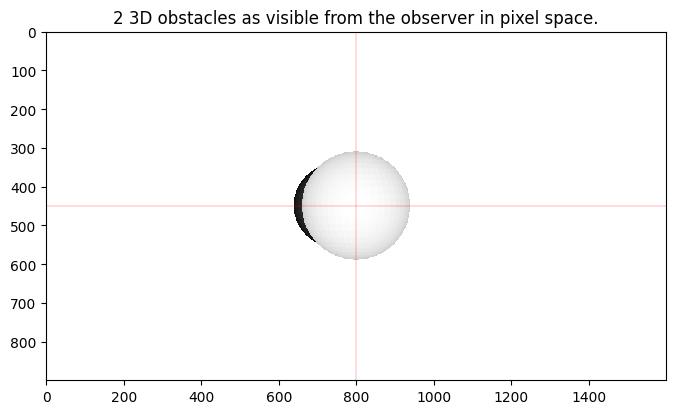

In [170]:
plt.figure(figsize=(8, 5))
plt.imshow(rasterizer._screen, cmap=plt.cm.gray_r, origin='upper', interpolation="nearest", vmax=None)

ax = plt.gca()
ax.axhline(H/2, color="red", lw=0.2)
ax.axvline(W/2, color="red", lw=0.2)
ax.set_title(f"{len(objects_world)} 3D obstacles as visible from the observer in pixel space.")

## Z-buffer for each object

In [173]:
z_buffers = [
    rasterize_object(object_triangles_screen,
                     object_mesh_original.triangles, screen=(W, H))
    for object_triangles_screen, object_mesh_original in zip(object_vertices_screen_list, objects_model)
]

## Visibility matrix for the scene including all objects

In [174]:
import itertools

In [175]:
V = -1*np.ones((H, W), dtype=int)
for i, j in itertools.product(range(H), range(W)):
    z_buffer_values = np.array([z_k[i, j] for z_k in z_buffers])
    if (z_buffer_values == np.inf).all():
        V[i, j] = -1
        continue
    V[i, j] = np.argmin(z_buffer_values)

## Compute visibility values for each object

In [176]:
visibility_values = list()

for k in range(len(objects_model)):
    vis_value = (V == k).sum() /(z_buffers[k] < np.inf).sum()
    visibility_values.append(vis_value)

In [177]:
visibility_values

[1.0, 0.08752765486725664]

(-0.5, 1599.5, 899.5, -0.5)

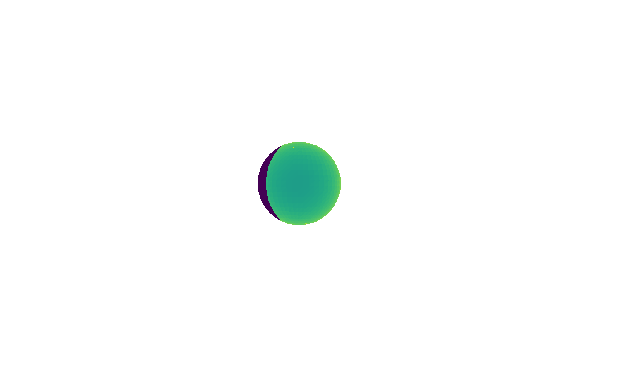

In [178]:
plt.figure(figsize=(8, 5))


k = 1  # object number

map_for_plot = z_buffers[k].copy()
map_for_plot[V==k] = 10
plt.imshow(map_for_plot, origin='upper', interpolation="nearest")
plt.axis('off')